In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

# Feature extraction and spatial analysis

Here, we will load a GTEx Small Intestine slide as example.

In [2]:
import pooch

slide = pooch.retrieve(
    url="https://brd.nci.nih.gov/brd/imagedownload/GTEX-11DXX-1626",
    fname="GTEX-11DXX-1626.svs",
    path=".",
    known_hash="sha256:b88f44637fdbb80f545642ee4ea7ea3d155bea533a9052c47c01580f55bd206c",
)

In [3]:
from wsidata import open_wsi
import lazyslide as zs

import matplotlib.pyplot as plt

Let's open the wsi! We set `store=None` so the associated spatialdata won't be loaded. A new one will be created.

WSI: /Users/yzheng/Projects/LazySlide/docs/source/tutorials/GTEX-11DXX-1626.svs
Reader: openslide
Dimensions: 38717×51791 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object
└── Images
      └── 'wsi_thumbnail': DataArray[cyx] (3, 1118, 1495)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images)
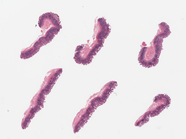

In [4]:
wsi = open_wsi(slide, store=None)
wsi

What does the tissue look like?

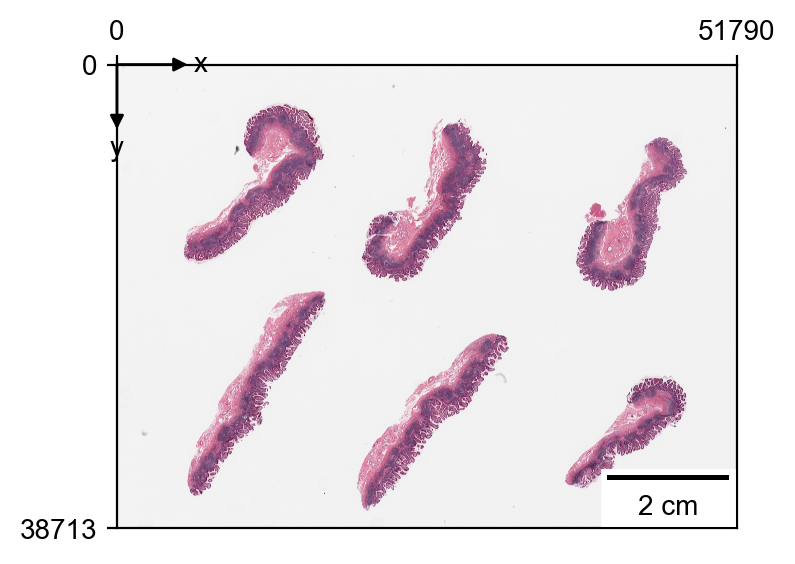

In [5]:
zs.pl.tissue(wsi)

Let's first find and tile the tissue, we will request tiny tile size of 64*64 px, this may take a while.

In [6]:
zs.pp.find_tissues(wsi)
zs.pp.tile_tissues(wsi, 64)

## Morphological feature extraction

Feature extraction is to transform the image into a the numeric representation, which comprises of different morphological features. Typically, this is done by feeding the tiles into a vision model.

LazySlide supports automatic mix-precision inference which may reduce memory usuage and have faster inference spped, try `amp=True`. Since we are working on a big slide with tiny tile sizes, this may take 10mins to finish (MacBook M3 Max).

::{note}
Autocast doesn't work well with mps backend though, you may get all nan results.

In [21]:
# zs.tl.feature_extraction(wsi, "h0-mini", amp=True)
zs.tl.feature_extraction(wsi, "h0-mini")

Output()

WSI: /Users/yzheng/Projects/LazySlide/docs/source/tutorials/GTEX-11DXX-1626.svs
Reader: openslide
Dimensions: 38717×51791 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1118, 1495)
├── Shapes
│     ├── 'tiles': GeoDataFrame shape: (77003, 3) (2D shapes)
│     └── 'tissues': GeoDataFrame shape: (6, 2) (2D shapes)
└── Tables
      └── 'h0-mini_tiles': AnnData (77003, 1536)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tiles (Shapes), tissues (Shapes)
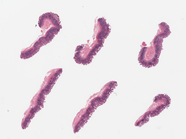

In [22]:
wsi

Features are saved as `AnnData` store with a convention of "{model name}_{tiles key}". For example, `h0-mini_tiles`

## Feature aggregation

To perform analysis across dataset, a usual way is to pool features into a 1D vector that can represent the entire slide. By default, the mean pooling is applied. Advanced slide encoders will be introduced later.

In [24]:
zs.tl.feature_aggregation(wsi, feature_key="h0-mini")

You can retrieve specific feature with the `fetch` accessor. This will return a copy of the anndata.

In [25]:
adata = wsi.fetch.features_anndata("h0-mini")

## Examination of feature space

In [26]:
import scanpy as sc

adata = wsi["h0-mini_tiles"]
sc.pp.scale(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor="igraph", resolution=0.2)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


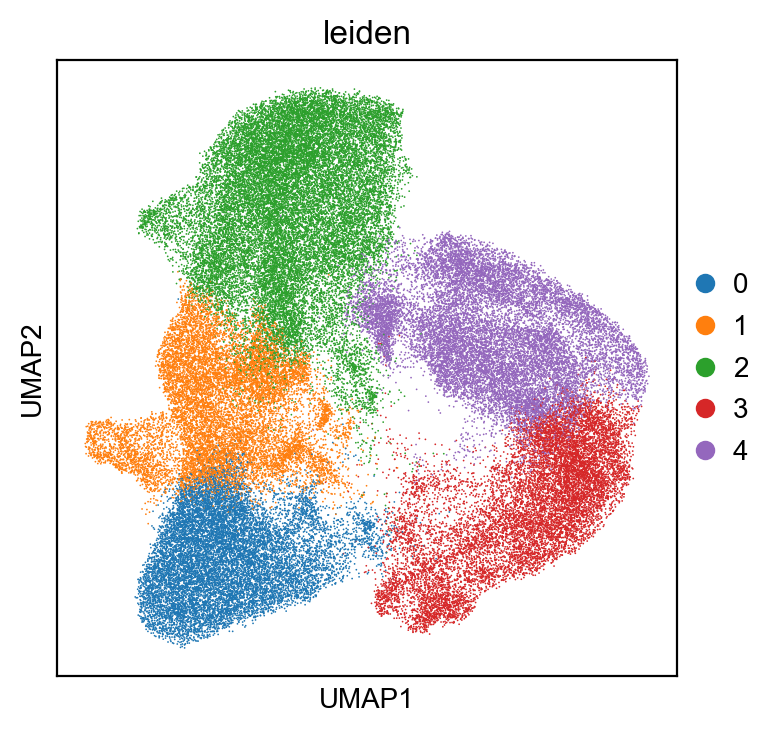

In [27]:
sc.pl.umap(adata, color="leiden")

In [34]:
sc.tl.rank_genes_groups(adata, groupby="leiden")

features = set()
for i in adata.obs["leiden"].unique():
    names = sc.get.rank_genes_groups_df(adata, "0").names
    features.update(list(names[0:20]) + list(names[-20:]))
features = list(features)

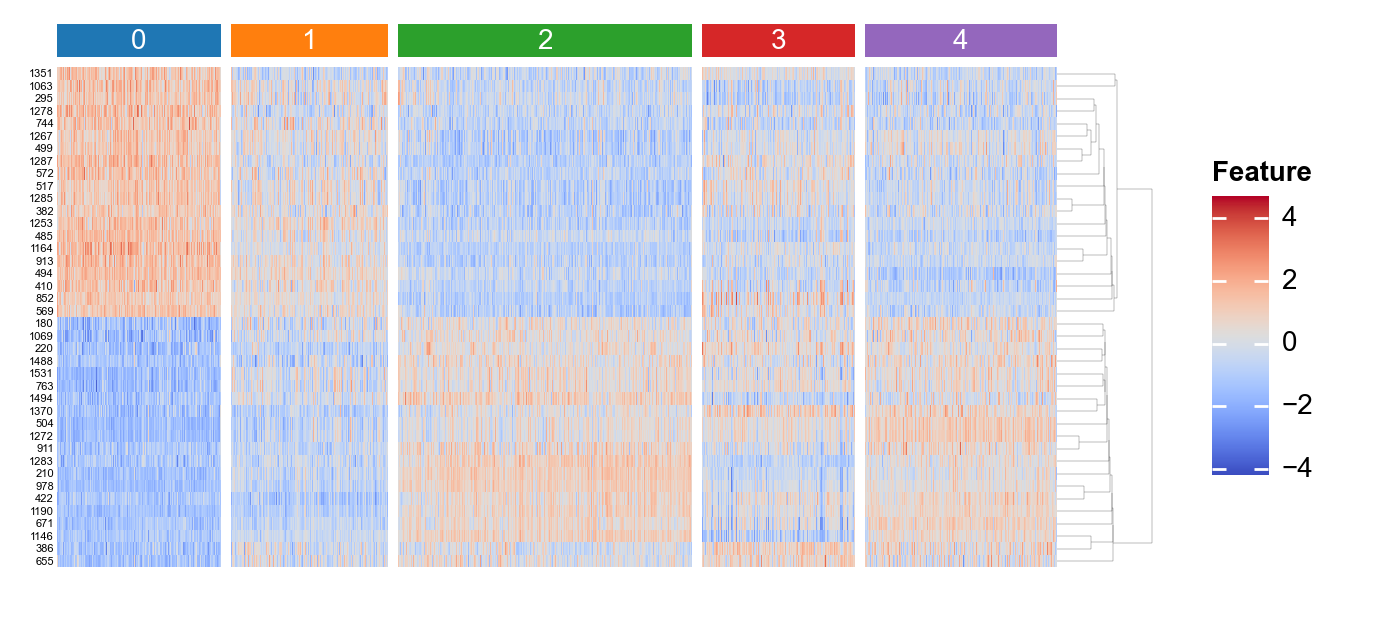

In [37]:
import marsilea as ma
import marsilea.plotter as mp
from scipy.stats import zscore

key = "leiden"
h = ma.Heatmap(adata[:, features].X.T, height=2.5, width=5, label="Feature")
order = sorted(adata.obs[key].unique())
h.group_cols(adata.obs[key], order=order)
h.add_top(mp.Chunk(order, fill_colors=adata.uns[f"{key}_colors"], padding=2), pad=0.05)
h.add_left(mp.Labels(features, fontsize=4))
h.add_dendrogram("right", linewidth=0.1)
h.add_legends()
h.render()

## Identification of spatial domains

The leiden clustering on features from foundational model can already recover the spatial domains of tissues pretty well.

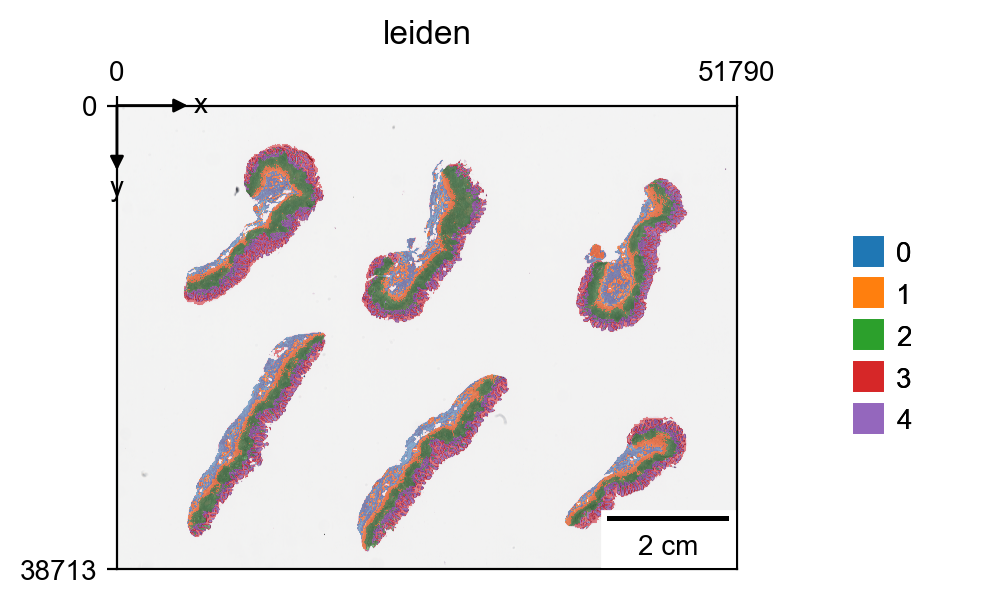

In [39]:
zs.pl.tiles(
    wsi,
    feature_key="h0-mini",
    color="leiden",
    alpha=0.5,
    palette=adata.uns[f"{key}_colors"],
    show_contours=False,
)

For simplicity, you can simply run spatial domain through:

In [ ]:
zs.tl.spatial_domain(wsi, feature_key="uni2", resolution=0.2)

The spatial domain is equivalent to the following process:

In [ ]:
wsi.write()

### Integration of spatial information with UTAG

In this example, you may notice the border of domain is not very smooth, this can be improved by integrating spatial information.

[UTAG](https://doi.org/10.1038/s41592-022-01657-2) is a method develop to discovery spatial domain with unsupervised learning.

In [40]:
zs.pp.tile_graph(wsi)
zs.tl.feature_utag(wsi, "h0-mini")

In [41]:
zs.tl.spatial_domain(wsi, layer="utag", feature_key="h0-mini", resolution=0.3)

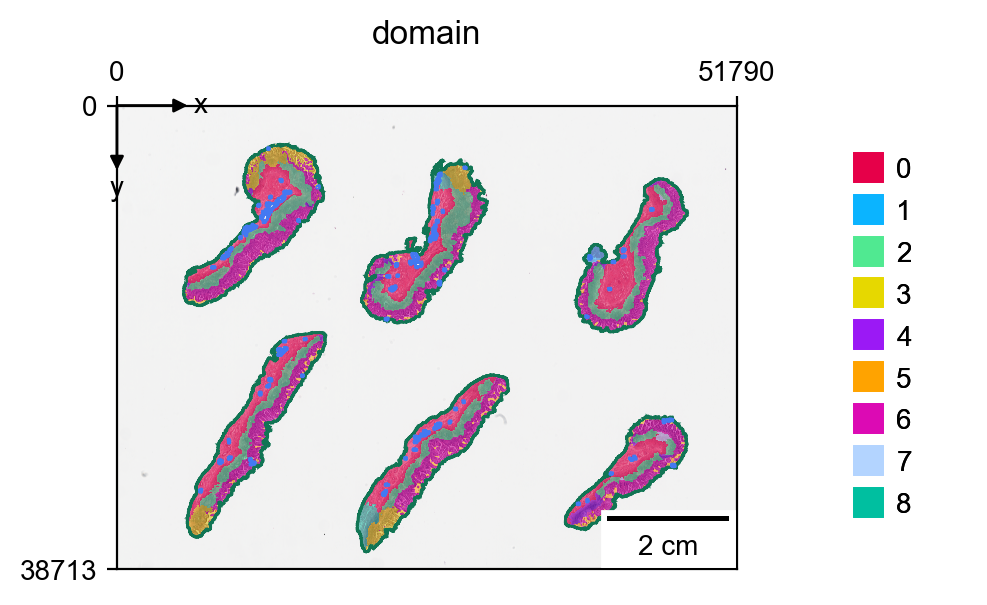

In [42]:
zs.pl.tiles(wsi, color="domain", alpha=0.5)

## Text feature extraction

Apart from deriving morphological features from vision models, you can also run multimodal to derive text features.

Currently, there are two vision-language models for pathology
- [PLIP](https://doi.org/10.1038/s41591-023-02504-3), Nature Medicine, 2023
- [CONCH](https://doi.org/10.1038/s41591-024-02856-4), Nature Medicine, 2024

We recommand using larger tile size for text features, a larger image contains more semantic context

In [43]:
zs.pp.tile_tissues(wsi, 128, mpp=0.5, key_added="text_tiles")
zs.tl.feature_extraction(wsi, "plip", tile_key="text_tiles")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Output()

In [44]:
terms = ["mucosa", "submucosa", "musclaris", "lymphocyte"]

embeddings = zs.tl.text_embedding(terms, model="plip")

In [45]:
zs.tl.text_image_similarity(wsi, embeddings, model="plip", tile_key="text_tiles")

In [ ]:
zs.pl.tiles(
    wsi,
    feature_key="plip_text_tiles_text_similarity",
    tile_key="text_tiles",
    color=terms,
    cmap="rainbow",
    show_image=True,
    tissue_id=3,
    # vmin=1.4,
    # vmax=2.4,
    alpha=0.7,
)

ax = plt.gca()
ax.set_axis_off()
plt.rcParams["svg.fonttype"] = "none"
plt.savefig("text_similarity.svg", dpi=300, bbox_inches="tight")

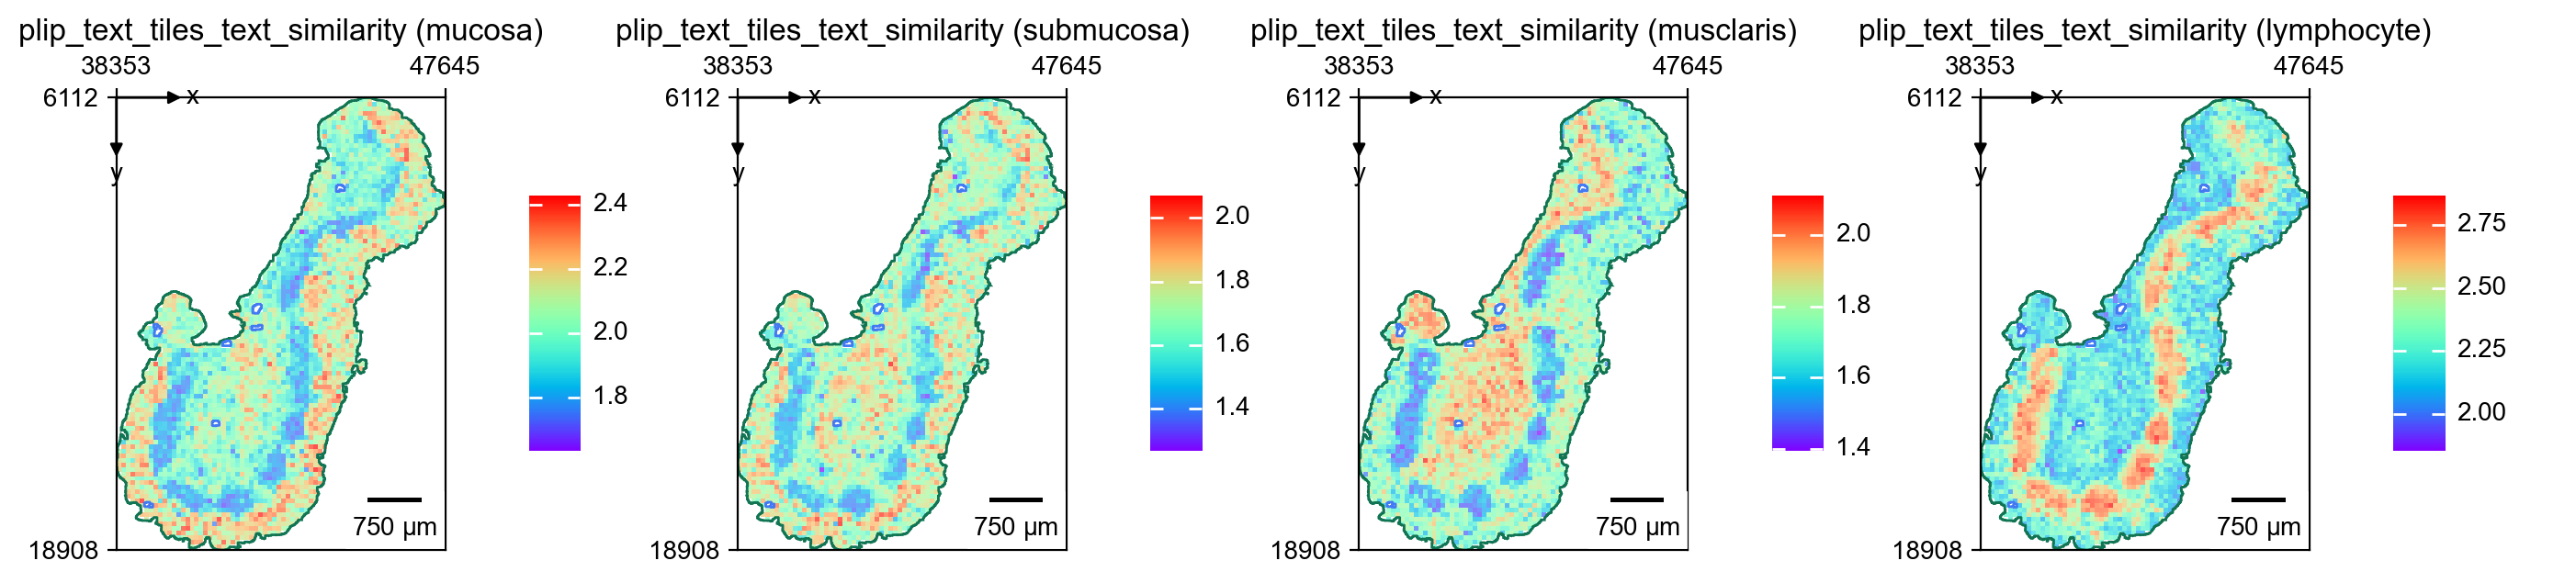

In [49]:
zs.pl.tiles(
    wsi,
    feature_key="plip_text_tiles_text_similarity",
    tile_key="text_tiles",
    color=terms,
    cmap="rainbow",
    show_image=False,
    tissue_id=3,
    ncols=2,
    alpha=0.7,
)